In this notebook, we provide example code for computing gravitional waveforms from extreme-mass-ratio inspirals using the local kludge scheme (AKA the Chimera) introduced in [Sopuerta & Yunes, 2011](https://arxiv.org/abs/1109.0572) (hereafter Ref. [1]). In the introduction we provide a brief overview of our numerical implementation of the Chimera in order to explain the user-level options in the evolution master functions.

# Introduction

Schematically, our implementation of the Chimera is as follows:

1. Numerically evolve the geodesic equation with the initial constants of motion and initial conditions for a time $\Delta{T}$.

2. Compute the multipole moment derivatives required for waveform waveform generation. (The metric perturbations are expressed in terms of time-asymmetric radiation reaction potentials which themselves are decomposed into several mass- and current-type multipole moments).

3. Compute the multipole moment derivatives required for the self-force computation.

4. Compute the self-acceleration, use this to update the constants of motion, and evolve the next piecewise geodesic with the updated constants. Continue until the EMRI has been evolved for the specified amount of time.

We provide different options for computing the high-order derivatives in steps (2-3) which vary in computational expense:


<ol type="i">
  <li>Estimate all the multipole moment derivatves using a least-squares fitting/optimization algorithm. This is the most computationally expensive option, but, in principle, is the most robust.<br>
  <br>
  <li>Estimate all the multipole moment derivatives using finite difference formulae. (We do not recommend this option. Though  we are yet to carry out convergence tests, we do not expect this approach to be reliable for inspirals across the entire parameter space.)<br>
  <br>
  <li>Estimate only the multipole moment derivatives required for the self-force computation using the more robust least-squares approach, and estimate those required for the waveform using finite differences. This approach is motivated by the fact that computing the fluxes of the constants of motion requires taking up to the sixth time derivative of time series data, while, to generate the waveform, we need only take up to two time derivatives. This leads to a significant speed up: there are 22 independent components of the multipole moments required for self-force computation, and 41 components for the waveform. Thus, by using finite differences for the waveform moments, we can reduce the number of fits we must perform by a factor of ~2/3.
</ol>

We recommend option using (iii). The robustness of option (i) when computing the high-order time derivatives for the self-force computation is combined with the speed of the finite differences approach for the lower-order derivatives where we do not expect catastrophic cancellation to occur. For further detail on our numerical implementation. See the preamble in <em>ChimeraInspiral.jl</em>.

The parameters of used in this notebook are set in the "params.jl" file, and are chosen to be consistent with Fig. 5 in Ref. [1], which depicts the evolution of the constants of motion for a generic inspiral in Kerr. We first evolve this for a short time (only ~3 hours), to show the consistency of options (i), (ii), and (iii). We then evolve this inspiral for the same duration as in Fig. 5 using options (ii) and (iii).

# Preliminaries

To change the number of threads, run the cell below and then change the notebook's kernel to the newly created one. The kernel might need to be refreshed before the new kernel comes up as an option.

In [1]:
# using IJulia
# installkernel("Julia 4 threads", env=Dict("JULIA_NUM_THREADS"=>"4"));
Threads.nthreads()

4

Upon running this notebook for the first time, the following cell must be evaluated.

In [2]:
# include("../dependencies.jl");

The underlying parameters used in this notebook can be changed in the "params.jl" file.

In [3]:
using HDF5, LaTeXStrings, Plots.PlotMeasures, Plots
include("params.jl");

# Comparing inspiral implementations over a short time

We first demonstrate three different inpsiral evolutions which differ in how they approximate the high order derivatives of the multipole moments. Note that these these inspirals are evolved for a (very short) time of ~3 hours.

The first, and slowest, approach evolves the inspiral in Boyer-Lindquist time and fits the all the independent components of every multipole moments to its fourier series in order to estimate their time derivatives. This takes around 3 minutes (which includes the contribution from JIT compilation).

In [4]:
include("compute_BL_FF_inspiral.jl");

File created: ../Results/Data/EMRI_sol_a_0.98_p_7.0_e_0.6_θmin_0.571_q_1.0e-5_psi0_3.142_chi0_0.0_phi0_0.0_nHarm_2_fit_range_factor_0.5_BL_fourier_GSL_fit.h5
173.812994 seconds (50.88 M allocations: 9.287 GiB, 1.61% gc time, 41.11% compilation time: <1% of which was recompilation)


The second (recommended) approach evolves the inspiral in Mino time, performing fits for the multipole moments required for the self-force computation, and using finite differences to compute the lower-order time derivatives of the multipole moments needed for waveform generation.

In [5]:
include("compute_Mino_FF_inspiral.jl");

File created: ../Results/Data/EMRI_sol_a_0.98_p_7.0_e_0.6_θmin_0.571_q_1.0e-5_psi0_3.142_chi0_0.0_phi0_0.0_nHarm_3_fit_range_factor_0.05_Mino_fourier_Julia_fit.h5
 17.891789 seconds (16.62 M allocations: 3.865 GiB, 3.63% gc time, 47.55% compilation time)


The final approach estimates all the time derivatives using finite difference methods (again, we are yet to carry out convergence tests for this approach).

In [6]:
include("compute_Mino_FDM_inspiral.jl");

File created: ../Results/Data/EMRI_sol_a_0.98_p_7.0_e_0.6_θmin_0.571_q_1.0e-5_psi0_3.142_chi0_0.0_phi0_0.0_h_0.001_Mino_fdm.h5
  6.778856 seconds (9.16 M allocations: 423.515 MiB, 1.49% gc time, 73.54% compilation time)


### Plot constants of motion

We first load the data from the three inspirals. The naming conventions below aren't as concise as they otherwise would be since, here, we have to distinguish between data from the different inspiral evolutions.

In [30]:
## BL Time Fourier Fit ##

# load trajectory
t_BL, r_BL, θ_BL, ϕ_BL, dr_dt_BL, dθ_dt_BL, dϕ_dt_BL, d2r_dt2_BL, d2θ_dt2_BL, d2ϕ_dt2_BL, dt_dτ_BL = ChimeraInspiral.FourierFit.BLTime.load_trajectory(a, p, e, θmin, q, psi0, chi0, phi0, nHarmGSL, t_range_factor_BL, gsl_fit, data_path);
t_BL = t_BL * MtoSecs; 

# load fluxes
t_Fluxes_BL, EE_BL, Edot_BL, LL_BL, Ldot_BL, QQ_BL, Qdot_BL, CC_BL, Cdot_BL, pArray_BL, ecc_BL, θmin_BL = ChimeraInspiral.FourierFit.BLTime.load_constants_of_motion(a, p, e, θmin, q, psi0, chi0, phi0, nHarmGSL, t_range_factor_BL, gsl_fit, data_path);
t_Fluxes_BL = t_Fluxes_BL * MtoSecs;

# compute iota
ι_BL = @. acos(LL_BL / sqrt(LL_BL^2 + CC_BL));

## Mino Time Fourier Fit ##

# load trajectory
λ_Mino_FF, t_Mino_FF, r_Mino_FF, θ_Mino_FF, ϕ_Mino_FF, dr_dt_Mino_FF, dθ_dt_Mino_FF, dϕ_dt_Mino_FF,
d2r_dt2_Mino_FF, d2θ_dt2_Mino_FF, d2ϕ_dt2_Mino_FF, dt_dτ_Mino_FF, dt_dλ_Mino_FF = ChimeraInspiral.FourierFit.MinoTime.load_trajectory(a, p, e, θmin, q, psi0, chi0, phi0, nHarmJulia, t_range_factor_Mino_FF, julia_fit, data_path);
t_Mino_FF = t_Mino_FF * MtoSecs;

# load fluxes
t_Fluxes_Mino_FF, EE_Mino_FF, Edot_Mino_FF, LL_Mino_FF, Ldot_Mino_FF, QQ_Mino_FF, Qdot_Mino_FF, CC_Mino_FF, Cdot_Mino_FF, pArray_Mino_FF, ecc_Mino_FF, θmin_Mino_FF = 
ChimeraInspiral.FourierFit.MinoTime.load_constants_of_motion(a, p, e, θmin, q, psi0, chi0, phi0, nHarmJulia, t_range_factor_Mino_FF, julia_fit, data_path);
t_Fluxes_Mino_FF = t_Fluxes_Mino_FF * MtoSecs;

# compute iota
ι_Mino_FF = @. acos(LL_Mino_FF / sqrt(LL_Mino_FF^2 + CC_Mino_FF));

## Mino Time FDM ##

# load trajectory
λ_Mino_FDM, t_Mino_FDM, r_Mino_FDM, θ_Mino_FDM, ϕ_Mino_FDM, dr_dt_Mino_FDM, dθ_dt_Mino_FDM,
dϕ_dt_Mino_FDM, d2r_dt2_Mino_FDM, d2θ_dt2_Mino_FDM, d2ϕ_dt2_Mino_FDM, dt_dτ_Mino_FDM, dt_dλ_Mino_FDM = ChimeraInspiral.FiniteDifferences.MinoTime.load_trajectory(a, p, e, θmin, q, psi0, chi0, phi0, h, data_path);
t_Mino_FDM = t_Mino_FDM * MtoSecs;

# load fluxes
t_Fluxes_Mino_FDM, EE_Mino_FDM, Edot_Mino_FDM, LL_Mino_FDM, Ldot_Mino_FDM, QQ_Mino_FDM, Qdot_Mino_FDM, CC_Mino_FDM, Cdot_Mino_FDM,
pArray_Mino_FDM, ecc_Mino_FDM, θmin_Mino_FDM = 
ChimeraInspiral.FiniteDifferences.MinoTime.load_constants_of_motion(a, p, e, θmin, q, psi0, chi0, phi0, h, data_path);
t_Fluxes_Mino_FDM = t_Fluxes_Mino_FDM * MtoSecs;

# compute_fluxes
ι_Mino_FDM = @. acos(LL_Mino_FDM / sqrt(LL_Mino_FDM^2 + CC_Mino_FDM));

In [31]:
# some plot attributes
gsl_col = :red
gsl_ls = :solid
gsl_lw = 2.0

mino_ff_col = :blue
mino_ff_ls = :dash
mino_ff_lw = 2.0

mino_fdm_col = :green
mino_fdm_ls = :dashdot
mino_fdm_lw = 2.0

wave_im_ratio = 5   # width / height
wave_height = 300; wave_width = wave_height * wave_im_ratio
xtickfontsize=10; ytickfontsize=10; guidefontsize=15;
# margins
left_margin = 8mm; right_margin=8mm; top_margin=8mm; bottom_margin=8mm;

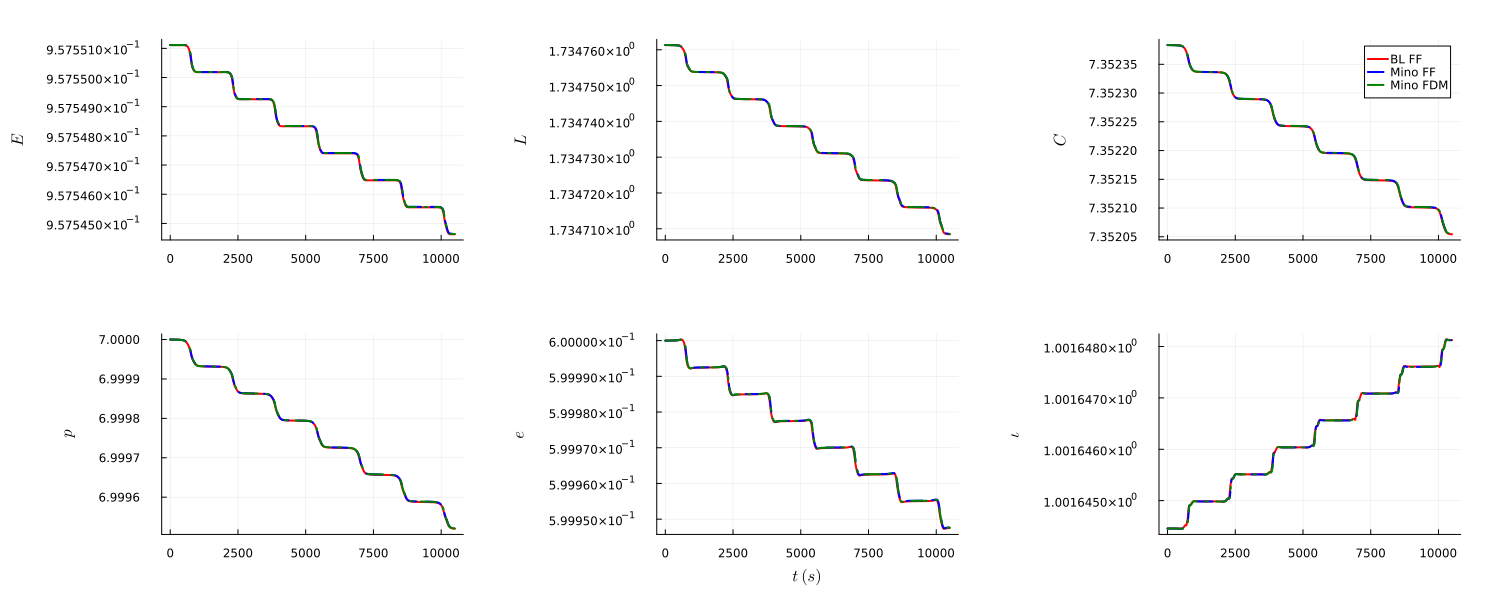

In [33]:
gr()
# plot BL results
plotE = Plots.plot(t_Fluxes_BL, EE_BL, ylabel=L"E", legend=:false,
    color=gsl_col, linestyle=gsl_ls, linewidth=gsl_lw,
    left_margin =  left_margin,
    right_margin =  right_margin,
    top_margin =  top_margin,
    bottom_margin =  bottom_margin)

plotL = Plots.plot(t_Fluxes_BL, LL_BL, ylabel=L"L", legend=:false,
    color=gsl_col, linestyle=gsl_ls, linewidth=gsl_lw,
    left_margin =  left_margin,
    right_margin =  right_margin,
    top_margin =  top_margin,
    bottom_margin =  bottom_margin)

plotC = Plots.plot(t_Fluxes_BL, CC_BL, ylabel=L"C", label="BL FF",
    color=gsl_col, linestyle=gsl_ls, linewidth=gsl_lw,
    left_margin =  left_margin,
    right_margin =  right_margin,
    top_margin =  top_margin,
    bottom_margin =  bottom_margin)

plotP = Plots.plot(t_Fluxes_BL, pArray_BL, ylabel=L"p", legend=:false, 
    color=gsl_col, linestyle=gsl_ls, linewidth=gsl_lw,
    left_margin =  left_margin,
    right_margin =  right_margin,
    top_margin =  top_margin,
    bottom_margin =  bottom_margin)

plotEcc = Plots.plot(t_Fluxes_BL, ecc_BL, ylabel=L"e", xlabel=L"t\ (s)", legend=:false,
    color=gsl_col, linestyle=gsl_ls, linewidth=gsl_lw,
    left_margin =  left_margin,
    right_margin =  right_margin,
    top_margin =  top_margin,
    bottom_margin =  bottom_margin)

plotι = Plots.plot(t_Fluxes_BL, ι_BL, ylabel=L"\iota", legend=:false,
    color=gsl_col, linestyle=gsl_ls, linewidth=gsl_lw,
    left_margin =  left_margin,
    right_margin =  right_margin,
    top_margin =  top_margin,
    bottom_margin =  bottom_margin)

# plot Mino FF results
Plots.plot!(plotE, t_Fluxes_Mino_FF, EE_Mino_FF, legend=:false, color=mino_ff_col, linestyle=mino_ff_ls, linewidth=mino_ff_lw)
Plots.plot!(plotL, t_Fluxes_Mino_FF, LL_Mino_FF, legend=:false, color=mino_ff_col, linestyle=mino_ff_ls, linewidth=mino_ff_lw)
Plots.plot!(plotC, t_Fluxes_Mino_FF, CC_Mino_FF, label="Mino FF", color=mino_ff_col, linestyle=mino_ff_ls, linewidth=mino_ff_lw)
Plots.plot!(plotP, t_Fluxes_Mino_FF, pArray_Mino_FF, legend=:false, color=mino_ff_col, linestyle=mino_ff_ls, linewidth=mino_ff_lw)
Plots.plot!(plotEcc, t_Fluxes_Mino_FF, ecc_Mino_FF, legend=:false, color=mino_ff_col, linestyle=mino_ff_ls, linewidth=mino_ff_lw)
Plots.plot!(plotι, t_Fluxes_Mino_FF, ι_Mino_FF, legend=:false, color=mino_ff_col, linestyle=mino_ff_ls, linewidth=mino_ff_lw)

# plot Mino FDM results
Plots.plot!(plotE, t_Fluxes_Mino_FDM, EE_Mino_FDM, legend=:false, color=mino_fdm_col, linestyle=mino_fdm_ls, linewidth=mino_fdm_lw)
Plots.plot!(plotL, t_Fluxes_Mino_FDM, LL_Mino_FDM, legend=:false, color=mino_fdm_col, linestyle=mino_fdm_ls, linewidth=mino_fdm_lw)
Plots.plot!(plotC, t_Fluxes_Mino_FDM, CC_Mino_FDM, label="Mino FDM", color=mino_fdm_col, linestyle=mino_fdm_ls, linewidth=mino_fdm_lw)
Plots.plot!(plotP, t_Fluxes_Mino_FDM, pArray_Mino_FDM, legend=:false, color=mino_fdm_col, linestyle=mino_fdm_ls, linewidth=mino_fdm_lw)
Plots.plot!(plotEcc, t_Fluxes_Mino_FDM, ecc_Mino_FDM, legend=:false, color=mino_fdm_col, linestyle=mino_fdm_ls, linewidth=mino_fdm_lw)
Plots.plot!(plotι, t_Fluxes_Mino_FDM, ι_Mino_FDM, legend=:false, color=mino_fdm_col, linestyle=mino_fdm_ls, linewidth=mino_fdm_lw)

orbitalParamsPlot=plot(plotE, plotL, plotC, plotP, plotEcc, plotι, layout = @layout([[A B C]; [D E F]]), 
size=(1500, 600), dpi=100)
display("image/png", orbitalParamsPlot)

### Gravitational waveform

We now plot the waveforms from the different approaches.

In [10]:
include("../ChimeraInspiral.jl")

Main.ChimeraInspiral

In [11]:
@time ChimeraInspiral.FourierFit.BLTime.compute_waveform(obs_distance, Θ, Φ, a, p, e, θmin, q, psi0, chi0, phi0, nHarmGSL, t_range_factor_BL, gsl_fit, data_path);
t_wf_BL, h_plus_BL, h_cross_BL = ChimeraInspiral.FourierFit.BLTime.load_waveform(obs_distance, Θ, Φ, a, p, e, θmin, q, psi0, chi0, phi0, nHarmGSL, t_range_factor_BL, gsl_fit, data_path);

@time ChimeraInspiral.FourierFit.MinoTime.compute_waveform(obs_distance, Θ, Φ, a, p, e, θmin, q, psi0, chi0, phi0, nHarmJulia, t_range_factor_Mino_FF, julia_fit, data_path);
t_wf_Mino_FF, h_plus_Mino_FF, h_cross_Mino_FF = ChimeraInspiral.FourierFit.MinoTime.load_waveform(obs_distance, Θ, Φ, a, p, e, θmin, q, psi0, chi0, phi0, nHarmJulia, t_range_factor_Mino_FF, julia_fit, data_path);

@time ChimeraInspiral.FiniteDifferences.MinoTime.compute_waveform(obs_distance, Θ, Φ, a, p, e, θmin, q, psi0, chi0, phi0, h, data_path);
t_wf_Mino_FDM, h_plus_Mino_FDM, h_cross_Mino_FDM = ChimeraInspiral.FiniteDifferences.MinoTime.load_waveform(obs_distance, Θ, Φ, a, p, e, θmin, q, psi0, chi0, phi0, h, data_path);

File created: ../Results/Data/Waveform_a_0.98_p_7.0_e_0.6_θmin_0.571_q_1.0e-5_psi0_3.142_chi0_0.0_phi0_0.0_obsDist_1.0_obsTheta_0.785_obsPhi_0.0_nHarm_2_fit_range_factor_0.5_BL_fourier_GSL_fit.jld2
  9.986683 seconds (551.87 M allocations: 8.634 GiB, 21.73% gc time, 53.87% compilation time: 19% of which was recompilation)
File created: ../Results/Data/Waveform_a_0.98_p_7.0_e_0.6_θmin_0.571_q_1.0e-5_psi0_3.142_chi0_0.0_phi0_0.0_obsDist_1.0_obsTheta_0.785_obsPhi_0.0_nHarm_3_fit_range_factor_0.05_Mino_fourier_Julia_fit.jld2
  0.999824 seconds (96.61 M allocations: 1.451 GiB, 41.40% gc time, 9.62% compilation time)
File created: ../Results/Data/Waveform_a_0.98_p_7.0_e_0.6_θmin_0.571_q_1.0e-5_psi0_3.142_chi0_0.0_phi0_0.0_obsDist_1.0_obsTheta_0.785_obsPhi_0.0_h_0.001_Mino_fdm.h5
  1.066553 seconds (98.29 M allocations: 1.476 GiB, 33.68% gc time, 7.98% compilation time)


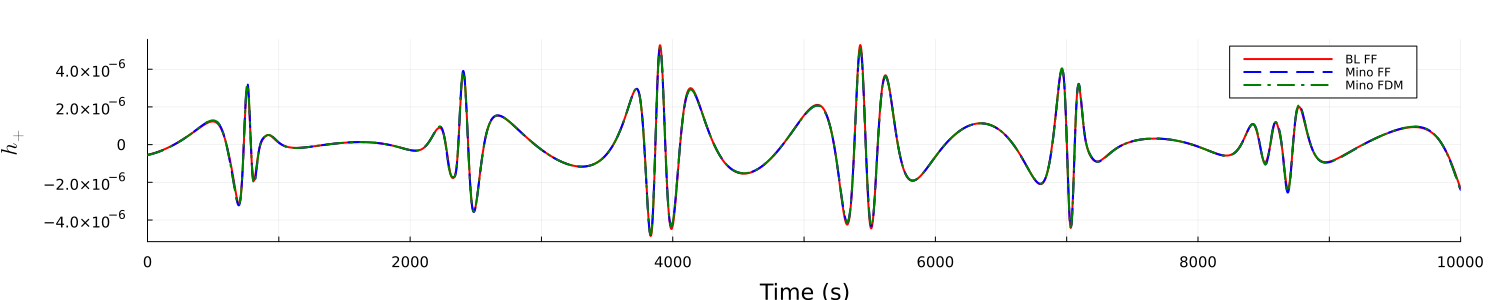

In [12]:
# plot
gr()
p1 = plot(t_BL, h_plus_BL, 
color=gsl_col,
linestyle=gsl_ls,
linewidth=gsl_lw,
xlims=(0, 10000),
legend =:topright,
xticks=(0:1000:10000, ["0", "", "2000", "", "4000", "", "6000", "", "8000", "", "10000"]),
xlabel = "Time (s)",
ylabel = L"h_{+}",
label = "BL FF",
size=(wave_width, wave_height),
left_margin		=  left_margin,
right_margin	=  right_margin,
top_margin		=  top_margin,
bottom_margin	=  bottom_margin,
xtickfontsize = xtickfontsize,
ytickfontsize = ytickfontsize,
guidefontsize = guidefontsize,
dpi=100)

plot!(t_Mino_FF, h_plus_Mino_FF, color=mino_ff_col, linestyle=mino_ff_ls, linewidth=mino_ff_lw, label="Mino FF")

plot!(t_Mino_FDM, h_plus_Mino_FDM, color=mino_fdm_col, linestyle=mino_fdm_ls, linewidth=mino_fdm_lw, label="Mino FDM")

display("image/png", p1)

# Comparing hybrid and full-FDM inspiral implementations over a longer time

We compare the fourier-fit-FDM hybrid implementation to the full-FDM inspiral for an inspiral evolved for 0.01 years (with the same parameters and duration as Fig. 5 in [1]). Warning: these inspirals will take ~7 minutes to compute.

In [13]:
t_max_secs = (10^-2) * year  # seconds
t_max_M = t_max_secs / MtoSecs;   # units of M

In [14]:
# plot attributes
mino_ff_col = :red
mino_ff_ls = :solid
mino_ff_lw = 2.0

mino_fdm_col = :blue
mino_fdm_ls = :dash
mino_fdm_lw = 2.0;

In [15]:
include("compute_Mino_FF_inspiral.jl");

File created: ../Results/Data/EMRI_sol_a_0.98_p_7.0_e_0.6_θmin_0.571_q_1.0e-5_psi0_3.142_chi0_0.0_phi0_0.0_nHarm_3_fit_range_factor_0.05_Mino_fourier_Julia_fit.h5
538.076163 seconds (262.16 M allocations: 98.419 GiB, 3.22% gc time, 0.40% compilation time)


In [16]:
include("compute_Mino_FDM_inspiral.jl");

File created: ../Results/Data/EMRI_sol_a_0.98_p_7.0_e_0.6_θmin_0.571_q_1.0e-5_psi0_3.142_chi0_0.0_phi0_0.0_h_0.001_Mino_fdm.h5
168.622104 seconds (207.28 M allocations: 7.544 GiB, 1.80% gc time, 2.32% compilation time)


### Plot constants of motion

In [17]:
## Fourier Fit ##

# load trajectory
λ_Mino_FF, t_Mino_FF, r_Mino_FF, θ_Mino_FF, ϕ_Mino_FF, dr_dt_Mino_FF, dθ_dt_Mino_FF, dϕ_dt_Mino_FF,
d2r_dt2_Mino_FF, d2θ_dt2_Mino_FF, d2ϕ_dt2_Mino_FF, dt_dτ_Mino_FF, dt_dλ_Mino_FF = ChimeraInspiral.FourierFit.MinoTime.load_trajectory(a, p, e, θmin, q, psi0, chi0, phi0, nHarmJulia, t_range_factor_Mino_FF, julia_fit, data_path);
t_Mino_FF = t_Mino_FF * MtoSecs;

# load fluxes
t_Fluxes_Mino_FF, EE_Mino_FF, Edot_Mino_FF, LL_Mino_FF, Ldot_Mino_FF, QQ_Mino_FF, Qdot_Mino_FF, CC_Mino_FF, Cdot_Mino_FF,
pArray_Mino_FF, ecc_Mino_FF, θmin_Mino_FF = ChimeraInspiral.FourierFit.MinoTime.load_constants_of_motion(a, p, e, θmin, q, psi0, chi0, phi0, nHarmJulia, t_range_factor_Mino_FF, julia_fit, data_path);
t_Fluxes_Mino_FF = t_Fluxes_Mino_FF * MtoSecs;

# compute iota
ι_Mino_FF = @. acos(LL_Mino_FF / sqrt(LL_Mino_FF^2 + CC_Mino_FF));

## FDM ##

# load trajectory
λ_Mino_FDM, t_Mino_FDM, r_Mino_FDM, θ_Mino_FDM, ϕ_Mino_FDM, dr_dt_Mino_FDM, dθ_dt_Mino_FDM,
dϕ_dt_Mino_FDM, d2r_dt2_Mino_FDM, d2θ_dt2_Mino_FDM, d2ϕ_dt2_Mino_FDM, dt_dτ_Mino_FDM, dt_dλ_Mino_FDM = ChimeraInspiral.FiniteDifferences.MinoTime.load_trajectory(a, p, e, θmin, q, psi0, chi0, phi0, h, data_path);
t_Mino_FDM = t_Mino_FDM * MtoSecs;

# load fluxes
t_Fluxes_Mino_FDM, EE_Mino_FDM, Edot_Mino_FDM, LL_Mino_FDM, Ldot_Mino_FDM, QQ_Mino_FDM, Qdot_Mino_FDM, CC_Mino_FDM, Cdot_Mino_FDM,
pArray_Mino_FDM, ecc_Mino_FDM, θmin_Mino_FDM = 
ChimeraInspiral.FiniteDifferences.MinoTime.load_constants_of_motion(a, p, e, θmin, q, psi0, chi0, phi0, h, data_path);
t_Fluxes_Mino_FDM = t_Fluxes_Mino_FDM * MtoSecs;

# compute_fluxes
ι_Mino_FDM = @. acos(LL_Mino_FDM / sqrt(LL_Mino_FDM^2 + CC_Mino_FDM));

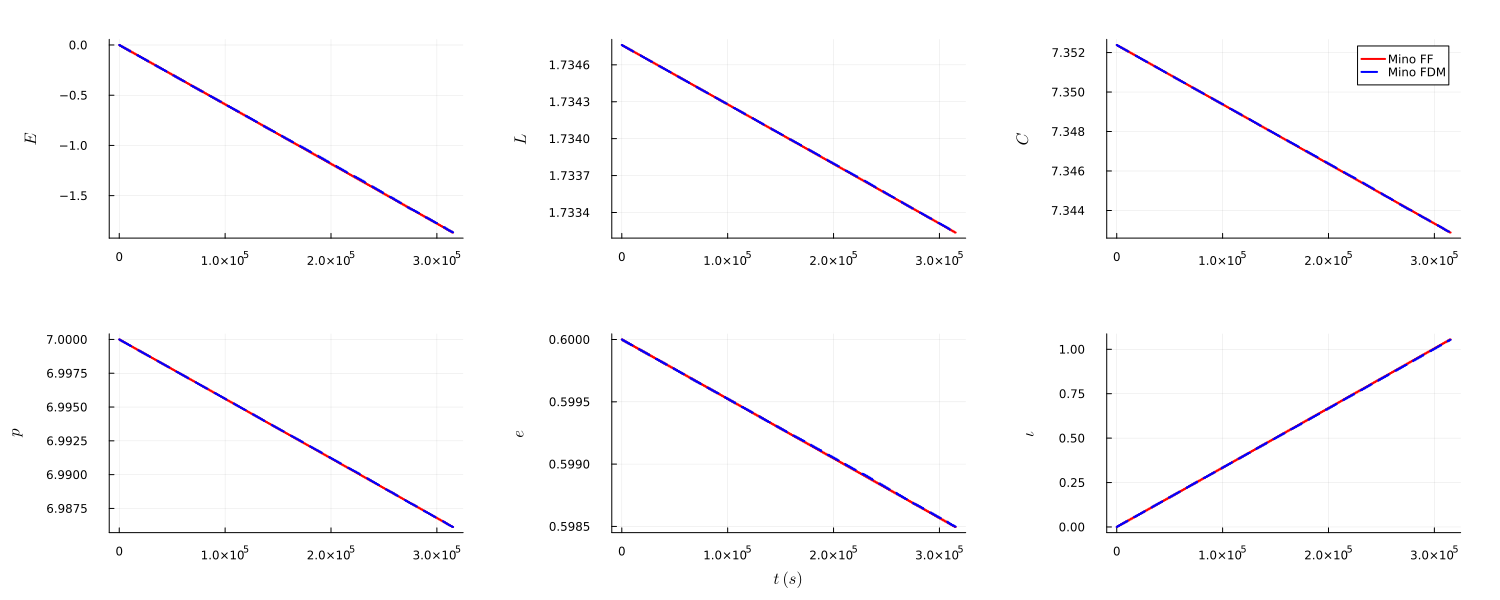

In [18]:
gr()
# plot Mino FF results
plotE = Plots.plot(t_Fluxes_Mino_FF, 1e4 * (EE_Mino_FF .- EE_Mino_FF[1]), ylabel=L"E", legend=:false,
    color=mino_ff_col, linestyle=mino_ff_ls, linewidth=mino_ff_lw,
    left_margin =  left_margin,
    right_margin =  right_margin,
    top_margin =  top_margin,
    bottom_margin =  bottom_margin)

plotL = Plots.plot(t_Fluxes_Mino_FF, LL_Mino_FF, ylabel=L"L", legend=:false,
    color=mino_ff_col, linestyle=mino_ff_ls, linewidth=mino_ff_lw,
    left_margin =  left_margin,
    right_margin =  right_margin,
    top_margin =  top_margin,
    bottom_margin =  bottom_margin)

plotC = Plots.plot(t_Fluxes_Mino_FF, CC_Mino_FF, ylabel=L"C", label="Mino FF",
    color=mino_ff_col, linestyle=mino_ff_ls, linewidth=mino_ff_lw,
    left_margin =  left_margin,
    right_margin =  right_margin,
    top_margin =  top_margin,
    bottom_margin =  bottom_margin)

plotP = Plots.plot(t_Fluxes_Mino_FF, pArray_Mino_FF, ylabel=L"p", legend=:false, 
    color=mino_ff_col, linestyle=mino_ff_ls, linewidth=mino_ff_lw,
    left_margin =  left_margin,
    right_margin =  right_margin,
    top_margin =  top_margin,
    bottom_margin =  bottom_margin)

plotEcc = Plots.plot(t_Fluxes_Mino_FF, ecc_Mino_FF, ylabel=L"e", xlabel=L"t\ (s)", legend=:false,
    color=mino_ff_col, linestyle=mino_ff_ls, linewidth=mino_ff_lw,
    left_margin =  left_margin,
    right_margin =  right_margin,
    top_margin =  top_margin,
    bottom_margin =  bottom_margin)

plotι = Plots.plot(t_Fluxes_Mino_FF, 1e4 * (ι_Mino_FF .- ι_Mino_FF[1]), ylabel=L"\iota", legend=:false,
    color=mino_ff_col, linestyle=mino_ff_ls, linewidth=mino_ff_lw,
    left_margin =  left_margin,
    right_margin =  right_margin,
    top_margin =  top_margin,
    bottom_margin =  bottom_margin)

# plot Mino FDM results
Plots.plot!(plotE, t_Fluxes_Mino_FDM, 1e4 * (EE_Mino_FDM .- EE_Mino_FDM[1]), legend=:false, color=mino_fdm_col, linestyle=mino_fdm_ls, linewidth=mino_fdm_lw)
Plots.plot!(plotL, t_Fluxes_Mino_FDM, LL_Mino_FDM, legend=:false, color=mino_fdm_col, linestyle=mino_fdm_ls, linewidth=mino_fdm_lw)
Plots.plot!(plotC, t_Fluxes_Mino_FDM, CC_Mino_FDM, label="Mino FDM", color=mino_fdm_col, linestyle=mino_fdm_ls, linewidth=mino_fdm_lw)
Plots.plot!(plotP, t_Fluxes_Mino_FDM, pArray_Mino_FDM, legend=:false, color=mino_fdm_col, linestyle=mino_fdm_ls, linewidth=mino_fdm_lw)
Plots.plot!(plotEcc, t_Fluxes_Mino_FDM, ecc_Mino_FDM, legend=:false, color=mino_fdm_col, linestyle=mino_fdm_ls, linewidth=mino_fdm_lw)
Plots.plot!(plotι, t_Fluxes_Mino_FDM,1e4 * (ι_Mino_FDM .- ι_Mino_FDM[1]), legend=:false, color=mino_fdm_col, linestyle=mino_fdm_ls, linewidth=mino_fdm_lw)

orbitalParamsPlot=plot(plotE, plotL, plotC, plotP, plotEcc, plotι, layout = @layout([[A B C]; [D E F]]), 
size=(1500, 600), dpi=100)
display("image/png", orbitalParamsPlot)

Note that we plot rescaled versions of $E$ and $\iota$— see the code in the cell above.

### Gravitational waveform

In [19]:
@time ChimeraInspiral.FourierFit.MinoTime.compute_waveform(obs_distance, Θ, Φ, a, p, e, θmin, q, psi0, chi0, phi0, nHarmJulia, t_range_factor_Mino_FF, julia_fit, data_path);
t_wf_Mino_FF, h_plus_Mino_FF, h_cross_Mino_FF = ChimeraInspiral.FourierFit.MinoTime.load_waveform(obs_distance, Θ, Φ, a, p, e, θmin, q, psi0, chi0, phi0, nHarmJulia, t_range_factor_Mino_FF, julia_fit, data_path);

@time ChimeraInspiral.FiniteDifferences.MinoTime.compute_waveform(obs_distance, Θ, Φ, a, p, e, θmin, q, psi0, chi0, phi0, h, data_path);
t_wf_Mino_FDM, h_plus_Mino_FDM, h_cross_Mino_FDM = ChimeraInspiral.FiniteDifferences.MinoTime.load_waveform(obs_distance, Θ, Φ, a, p, e, θmin, q, psi0, chi0, phi0, h, data_path);

File created: ../Results/Data/Waveform_a_0.98_p_7.0_e_0.6_θmin_0.571_q_1.0e-5_psi0_3.142_chi0_0.0_phi0_0.0_obsDist_1.0_obsTheta_0.785_obsPhi_0.0_nHarm_3_fit_range_factor_0.05_Mino_fourier_Julia_fit.jld2
 43.148081 seconds (2.84 G allocations: 42.522 GiB, 29.85% gc time)
File created: ../Results/Data/Waveform_a_0.98_p_7.0_e_0.6_θmin_0.571_q_1.0e-5_psi0_3.142_chi0_0.0_phi0_0.0_obsDist_1.0_obsTheta_0.785_obsPhi_0.0_h_0.001_Mino_fdm.h5
 44.978972 seconds (2.88 G allocations: 43.159 GiB, 30.55% gc time)


Below we plot the final 10,000 seconds of the waveform

In [28]:
tF = minimum([maximum(t_Mino_FF), maximum(t_Mino_FDM)])
t_Mino_FF_plot = t_Mino_FF .- (tF - 10000);
t_Mino_FDM_plot = t_Mino_FDM .- (tF - 10000);

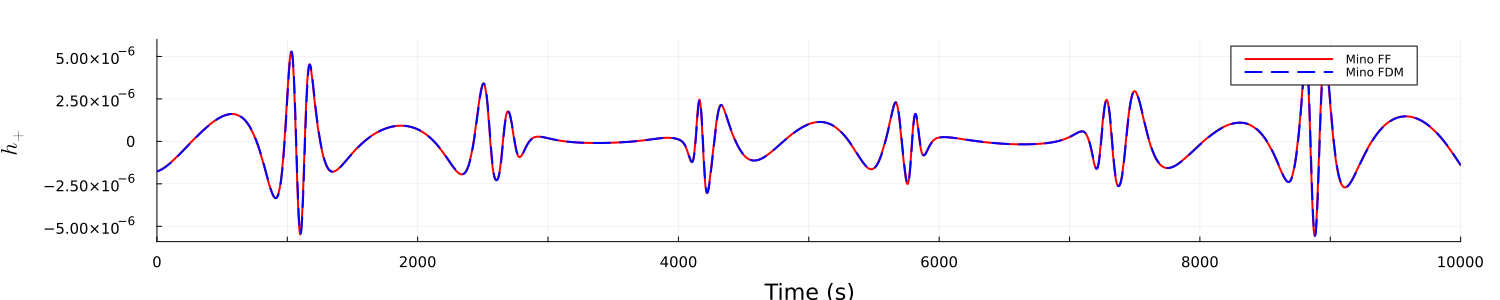

In [29]:
# plot
gr()
p1 = plot(t_Mino_FF_plot, h_plus_Mino_FF, 
color=mino_ff_col,
linestyle=mino_ff_ls,
linewidth=mino_ff_lw,
xlims=(0, 10000),
legend =:topright,
xticks=(0:1000:10000, ["0", "", "2000", "", "4000", "", "6000", "", "8000", "", "10000"]),
xlabel = "Time (s)",
ylabel = L"h_{+}",
label = "Mino FF",
size=(wave_width, wave_height),
left_margin		=  left_margin,
right_margin	=  right_margin,
top_margin		=  top_margin,
bottom_margin	=  bottom_margin,
xtickfontsize = xtickfontsize,
ytickfontsize = ytickfontsize,
guidefontsize = guidefontsize,
dpi=100)

plot!(t_Mino_FDM_plot, h_plus_Mino_FDM, color=mino_fdm_col, linestyle=mino_fdm_ls, linewidth=mino_fdm_lw, label="Mino FDM")

display("image/png", p1)

## References

[1] Sopuerta, C., & Yunes, N. New Kludge Scheme for the Construction of Approximate Waveforms for Extreme-Mass-Ratio Inspirals. [arXiv:1109.0572](https://arxiv.org/abs/1109.0572)